In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics  #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

%matplotlib inline

In [101]:
X = pd.read_pickle('feature_df.pkl')
y = pd.read_pickle('target.pkl')

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

Random forest: initial tuning of parameters

In [103]:
clf = RandomForestClassifier(n_jobs=-1, max_depth=25, max_features=25, min_samples_split=5, 
                             n_estimators=1000, oob_score=True, class_weight={0: 0.55, 1:0.45})
clf.fit(X_train, y_train)

In [104]:
prob = clf.predict_proba(X_test)[:,1]
prob

array([0.0316367 , 0.07380303, 0.05364235, ..., 0.00721531, 0.36487715,
       0.02996452])

In [25]:
thr = np.arange(0.01, 0.2, 0.01)
#thr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,0.15, 0.2, 0.25, 0.3, 0.35]
recalls = []
precisions = []
y_pred = []

In [26]:
for t in thr:
    y_pred = [1 if x > t else 0 for x in prob]
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recalls.append(recall)
    precisions.append(precision)
    print('for ',t)
    print('recall: ', recall_score(y_test, y_pred))
    print('precision: ', precision_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred).ravel())
    print('f1 score: ', f1_score(y_test, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    print(metrics.auc(fpr, tpr))

for  0.01
recall:  0.9344773790951638
precision:  0.09226740603820087
[ 976 5893   42  599]
f1 score:  0.16795177344735737
0.5382825096087263
for  0.02
recall:  0.8954758190327613
precision:  0.09903381642512077
[1647 5222   67  574]
f1 score:  0.17834394904458598
0.5676243558695616
for  0.03
recall:  0.8361934477379095
precision:  0.10256410256410256
[2179 4690  105  536]
f1 score:  0.18271689108573375
0.5767078754193988
for  0.04
recall:  0.7925117004680188
precision:  0.10903627387851471
[2718 4151  133  508]
f1 score:  0.19169811320754718
0.5941012425764174
for  0.05
recall:  0.7566302652106084
precision:  0.11583472653451159
[3167 3702  156  485]
f1 score:  0.20091135045567524
0.6088435938078082
for  0.060000000000000005
recall:  0.7129485179407177
precision:  0.1230479267635972
[3612 3257  184  457]
f1 score:  0.20987370838117106
0.619394625835987
for  0.06999999999999999
recall:  0.6645865834633385
precision:  0.1276595744680851
[3958 2911  215  426]
f1 score:  0.214177978883861

In [105]:
t = 0.02
y_pred = [1 if x > t else 0 for x in prob]
fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
roc_auc = metrics.auc(fpr, tpr)

Text(0.5,15,'False Positive Rate')

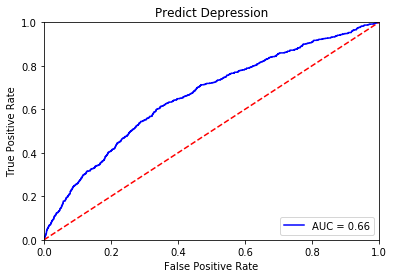

In [106]:
plt.title('Predict Depression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [107]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [108]:
feature_importances.index


Index([ 'IRALCFY', 'IRALCAGE', 'IRCIGAGE',   'SUMAGE', 'IRCGRAGE', 'EDUCCAT2',
         'IRMJFY',  'IRCIGFM',   'INCOME',   'CATAG6',  'IRANLFY',  'IRTRNFY',
       'IRSNFAGE', 'NEWRACE2',  'IRSTMFY',  'IRHALFY',  'IRCOCFY',    'IRSEX',
        'IRINHFY', 'DPILLALC', 'IRCRKAGE',    'CIGYR', 'ABODILAL',  'IRSEDFY',
          'CGRYR',          2,  'TOBFLAG',          7,    'SUMYR',          6,
          'ALCYR',          5,  'SNFFLAG',    'SNFYR',  'IRHERFY',          3,
                4,  'IRCRKFY',  'SUMFLAG',  'ALCFLAG', 'DEPNDMRJ',  'CRKFLAG',
          'CRKYR'],
      dtype='object')

Randomized search on Random Forest clf

In [33]:
param_grid = {
    'min_samples_split': [2,3,5,10], 
    'n_estimators' : [75, 200, 300, 500, 1000],
    'max_depth': [15, 25, 28, 30],
    'max_features': [3, 5, 10, 20, 25],
    'criterion' : ['gini', 'entropy']
}

In [34]:
clf = RandomForestClassifier(n_jobs=-1)


In [36]:
randomized_search = RandomizedSearchCV(clf, param_grid, n_iter=100, verbose=10, scoring='f1', return_train_score=True, n_jobs=-1)


In [39]:
randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=300, min_samples_split=5, max_features=25, max_depth=28, criterion=entropy 
[CV] n_estimators=300, min_samples_split=5, max_features=25, max_depth=28, criterion=entropy 
[CV] n_estimators=300, min_samples_split=5, max_features=25, max_depth=28, criterion=entropy 
[CV] n_estimators=75, min_samples_split=2, max_features=5, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=2, max_features=5, max_depth=15, criterion=gini, score=0.0048367593712212815, total=   2.5s
[CV] n_estimators=75, min_samples_split=2, max_features=5, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=2, max_features=5, max_depth=15, criterion=gini, score=0.004842615012106537, total=   3.0s
[CV] n_estimators=75, min_samples_split=2, max_features=5, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=2, max_features=5, max_depth=15, criterion=gini, score=0.0024183796856106408, tota

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   37.7s


[CV]  n_estimators=75, min_samples_split=10, max_features=20, max_depth=28, criterion=gini, score=0.016568047337278107, total=   4.7s
[CV] n_estimators=75, min_samples_split=10, max_features=20, max_depth=28, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=20, max_depth=28, criterion=gini, score=0.02364066193853428, total=   7.9s
[CV] n_estimators=75, min_samples_split=10, max_features=20, max_depth=28, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=20, max_depth=28, criterion=gini, score=0.011848341232227489, total=  10.7s
[CV] n_estimators=300, min_samples_split=10, max_features=3, max_depth=25, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, max_features=3, max_depth=25, criterion=gini, score=0.0, total=  12.3s
[CV] n_estimators=300, min_samples_split=10, max_features=3, max_depth=25, criterion=gini 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min


[CV]  n_estimators=1000, min_samples_split=2, max_features=10, max_depth=30, criterion=entropy, score=0.01645123384253819, total= 1.2min
[CV] n_estimators=300, min_samples_split=10, max_features=3, max_depth=25, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, max_features=3, max_depth=25, criterion=gini, score=0.0, total=  11.0s
[CV] n_estimators=75, min_samples_split=3, max_features=5, max_depth=15, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=75, min_samples_split=3, max_features=5, max_depth=15, criterion=gini, score=0.0, total=   3.5s
[CV] n_estimators=75, min_samples_split=3, max_features=5, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=3, max_features=5, max_depth=15, criterion=gini, score=0.0048250904704463205, total=   2.9s
[CV] n_estimators=75, min_samples_split=3, max_features=5, max_depth=15, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, max_features=3, max_depth=25, criterion=gini, score=0.0, total=  11.5s
[CV] n_estimators=500, min_samples_split=10, max_features=10, max_depth=25, criterion=entropy 
[CV]  n_estimators=75, min_samples_split=3, max_features=5, max_depth=15, criterion=gini, score=0.0024242424242424242, total=   3.0s
[CV] n_estimators=500, min_samples_split=10, max_features=10, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=2, max_features=10, max_depth=30, criterion=entropy, score=0.009445100354191263, total= 1.2min
[CV]  n_estimators=1000, min_samples_split=2, max_features=10, max_depth=30, criterion=entropy, score=0.01175088131609871, total= 1.2min


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min


[CV] n_estimators=500, min_samples_split=10, max_features=10, max_depth=25, criterion=entropy 
[CV] n_estimators=1000, min_samples_split=10, max_features=25, max_depth=25, criterion=gini 
[CV]  n_estimators=500, min_samples_split=10, max_features=10, max_depth=25, criterion=entropy, score=0.0024183796856106408, total=  30.9s
[CV] n_estimators=1000, min_samples_split=10, max_features=25, max_depth=25, criterion=gini 
[CV]  n_estimators=500, min_samples_split=10, max_features=10, max_depth=25, criterion=entropy, score=0.004830917874396135, total=  31.2s
[CV] n_estimators=1000, min_samples_split=10, max_features=25, max_depth=25, criterion=gini 
[CV]  n_estimators=500, min_samples_split=10, max_features=10, max_depth=25, criterion=entropy, score=0.0024183796856106408, total=  28.9s
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=gini, score=0.0, total=  17.7s
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=gini 
[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=gini, score=0.0024242424242424242, total=  18.9s
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=gini, score=0.0, total=  18.5s
[CV] n_estimators=75, min_samples_split=10, max_features=5, max_depth=28, criterion=gini 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.5min


[CV]  n_estimators=75, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.0024213075060532684, total=   3.1s
[CV] n_estimators=75, min_samples_split=10, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.004830917874396135, total=   3.2s
[CV] n_estimators=75, min_samples_split=10, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.002427184466019417, total=   3.2s
[CV] n_estimators=200, min_samples_split=2, max_features=25, max_depth=25, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=10, max_features=25, max_depth=25, criterion=gini, score=0.021276595744680854, total= 2.1min
[CV] n_estimators=200, min_samples_split=2, max_features=25, max_depth=25, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, max_features=25, max_depth=25, criterion=gini, score=0.03

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.6min


[CV]  n_estimators=500, min_samples_split=5, max_features=10, max_depth=25, criterion=gini, score=0.0048192771084337345, total=  29.5s
[CV] n_estimators=1000, min_samples_split=5, max_features=5, max_depth=25, criterion=gini 
[CV]  n_estimators=500, min_samples_split=5, max_features=10, max_depth=25, criterion=gini, score=0.016746411483253586, total=  30.2s
[CV] n_estimators=1000, min_samples_split=5, max_features=5, max_depth=25, criterion=gini 
[CV]  n_estimators=500, min_samples_split=5, max_features=10, max_depth=25, criterion=gini, score=0.0024067388688327313, total=  29.6s
[CV] n_estimators=200, min_samples_split=2, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, max_features=5, max_depth=28, criterion=gini, score=0.007177033492822967, total=  10.1s
[CV] n_estimators=200, min_samples_split=2, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=5, max_features=5, max_depth=25, criterion=gini, score=0.0

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, max_features=3, max_depth=28, criterion=entropy, score=0.0, total=   9.9s
[CV] n_estimators=300, min_samples_split=10, max_features=3, max_depth=28, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=1000, min_samples_split=10, max_features=3, max_depth=30, criterion=gini, score=0.0, total=  33.5s
[CV] n_estimators=300, min_samples_split=10, max_features=3, max_depth=28, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, max_features=3, max_depth=28, criterion=entropy, score=0.0, total=  11.4s
[CV] n_estimators=1000, min_samples_split=5, max_features=20, max_depth=28, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=10, max_features=3, max_depth=30, criterion=gini, score=0.0, total=  35.3s
[CV] n_estimators=1000, min_samples_split=5, max_features=20, max_depth=28, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, max_features=3, max_depth=28, criterion=entropy, score=0.0, total=  10.6s
[CV] n_estimators=1000, min_samples_split=5, max_features=20, max_depth=28, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=1000, min_samples_split=10, max_features=3, max_depth=30, criterion=gini, score=0.0, total=  33.8s
[CV] n_estimators=300, min_samples_split=2, max_features=10, max_depth=15, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=2, max_features=10, max_depth=15, criterion=entropy, score=0.0024213075060532684, total=  16.6s
[CV] n_estimators=300, min_samples_split=2, max_features=10, max_depth=15, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=2, max_features=10, max_depth=15, criterion=entropy, score=0.004830917874396135, total=  16.7s
[CV] n_estimators=300, min_samples_split=2, max_features=10, max_depth=15, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=2, max_features=10, max_depth=15, criterion=entropy, score=0.0, total=  16.6s
[CV] n_estimators=200, min_samples_split=10, max_features=20, max_depth=25, criterion=gini 
[CV]  n_estimators=200, min_samples_split=10, max_features=20, max_depth=25, criterion=gini, score=0.018957345971

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.0min


[CV] n_estimators=200, min_samples_split=10, max_features=20, max_depth=25, criterion=gini 
[CV]  n_estimators=200, min_samples_split=10, max_features=20, max_depth=25, criterion=gini, score=0.01664684898929845, total=  20.7s
[CV] n_estimators=300, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=5, max_features=20, max_depth=28, criterion=gini, score=0.018867924528301886, total= 1.7min
[CV] n_estimators=300, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=5, max_features=20, max_depth=28, criterion=gini, score=0.016568047337278104, total= 1.7min
[CV] n_estimators=300, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=10, max_features=20, max_depth=25, criterion=gini, score=0.011890606420927466, total=  19.1s
[CV] n_estimators=300, min_samples_split=5, max_features=5, max_depth=25, criterion=

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  8.9min


[CV]  n_estimators=300, min_samples_split=2, max_features=3, max_depth=28, criterion=entropy, score=0.0071428571428571435, total=  13.2s
[CV] n_estimators=300, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=2, max_features=3, max_depth=28, criterion=entropy, score=0.00954653937947494, total=  11.3s
[CV] n_estimators=300, min_samples_split=10, max_features=10, max_depth=25, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy, score=0.01413427561837456, total=  18.3s
[CV] n_estimators=300, min_samples_split=10, max_features=10, max_depth=25, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy, score=0.009456264775413711, total=  19.0s
[CV] n_estimators=300, min_samples_split=10, max_features=10, max_depth=25, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, max_features=10, max_depth=28, criterion

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 10.4min


[CV]  n_estimators=500, min_samples_split=2, max_features=25, max_depth=25, criterion=gini, score=0.025404157043879907, total= 1.0min
[CV] n_estimators=1000, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=3, max_features=25, max_depth=30, criterion=gini, score=0.030338389731621937, total= 1.0min
[CV] n_estimators=1000, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=  30.6s
[CV] n_estimators=1000, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=3, max_features=25, max_depth=30, criterion=gini, score=0.02306805074971165, total=  58.9s
[CV] n_estimators=1000, min_samples_split=2, max_features=20, max_depth=30, criterion=gini 
[CV]  n_estimators=500, min_samples_split=3, max_features=25, max_depth=30, criterion=gini, score=0.018561484918793503, total=  59.2s
[CV] n_estimators=1000, min_samples_split=2, max_features=20, max_depth=30, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=1000, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=  27.4s
[CV] n_estimators=1000, min_samples_split=2, max_features=20, max_depth=30, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=  28.1s
[CV] n_estimators=300, min_samples_split=2, max_features=20, max_depth=25, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, max_features=20, max_depth=25, criterion=gini, score=0.032407407407407406, total=  30.5s
[CV] n_estimators=300, min_samples_split=2, max_features=20, max_depth=25, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, max_features=20, max_depth=25, criterion=gini, score=0.020881670533642694, total=  31.3s
[CV] n_estimators=300, min_samples_split=2, max_features=20, max_depth=25, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=2, max_features=20, max_depth=30, criterion=gini, score=0.03214695752009185, total= 

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 13.4min


[CV] n_estimators=75, min_samples_split=5, max_features=3, max_depth=28, criterion=gini 
[CV]  n_estimators=75, min_samples_split=5, max_features=3, max_depth=28, criterion=gini, score=0.0024242424242424242, total=   2.9s
[CV] n_estimators=75, min_samples_split=5, max_features=3, max_depth=28, criterion=gini 
[CV]  n_estimators=75, min_samples_split=5, max_features=3, max_depth=28, criterion=gini, score=0.0024183796856106408, total=   2.9s
[CV] n_estimators=75, min_samples_split=5, max_features=3, max_depth=28, criterion=gini 
[CV]  n_estimators=500, min_samples_split=5, max_features=5, max_depth=30, criterion=gini, score=0.0024242424242424242, total=  21.7s
[CV] n_estimators=75, min_samples_split=5, max_features=20, max_depth=30, criterion=gini 
[CV]  n_estimators=75, min_samples_split=5, max_features=3, max_depth=28, criterion=gini, score=0.0, total=   2.8s
[CV] n_estimators=75, min_samples_split=5, max_features=20, max_depth=30, criterion=gini 
[CV]  n_estimators=500, min_samples_sp

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 14.4min


[CV]  n_estimators=200, min_samples_split=5, max_features=3, max_depth=30, criterion=gini, score=0.0024242424242424242, total=   7.0s
[CV] n_estimators=200, min_samples_split=5, max_features=3, max_depth=30, criterion=gini 
[CV]  n_estimators=200, min_samples_split=5, max_features=3, max_depth=30, criterion=gini, score=0.0, total=   7.2s
[CV] n_estimators=200, min_samples_split=5, max_features=3, max_depth=30, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=5, max_features=3, max_depth=30, criterion=gini, score=0.0, total=   7.2s
[CV] n_estimators=500, min_samples_split=3, max_features=10, max_depth=15, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=3, max_features=10, max_depth=15, criterion=entropy, score=0.0024213075060532684, total=  27.7s
[CV] n_estimators=500, min_samples_split=3, max_features=10, max_depth=15, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=5, max_features=25, max_depth=15, criterion=gini, score=0.016587677725118485, total= 1.7min
[CV] n_estimators=500, min_samples_split=3, max_features=10, max_depth=15, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=5, max_features=25, max_depth=15, criterion=gini, score=0.019047619047619046, total= 1.7min
[CV] n_estimators=1000, min_samples_split=3, max_features=3, max_depth=28, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=5, max_features=25, max_depth=15, criterion=gini, score=0.01

/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=entropy, score=0.0, total=  20.6s
[CV] n_estimators=500, min_samples_split=2, max_features=20, max_depth=30, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=3, max_features=3, max_depth=28, criterion=gini, score=0.0, total=  41.1s
[CV] n_estimators=500, min_samples_split=2, max_features=20, max_depth=30, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=entropy, score=0.0, total=  16.3s
[CV] n_estimators=500, min_samples_split=2, max_features=20, max_depth=30, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=30, criterion=entropy, score=0.0, total=  16.5s
[CV] n_estimators=75, min_samples_split=5, max_features=3, max_depth=30, criterion=gini 


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 16.7min


[CV]  n_estimators=75, min_samples_split=5, max_features=3, max_depth=30, criterion=gini, score=0.0024242424242424242, total=   2.3s
[CV] n_estimators=75, min_samples_split=5, max_features=3, max_depth=30, criterion=gini 
[CV]  n_estimators=75, min_samples_split=5, max_features=3, max_depth=30, criterion=gini, score=0.0, total=   2.6s
[CV] n_estimators=75, min_samples_split=5, max_features=3, max_depth=30, criterion=gini 
[CV]  n_estimators=75, min_samples_split=5, max_features=3, max_depth=30, criterion=gini, score=0.0, total=   2.6s
[CV] n_estimators=300, min_samples_split=2, max_features=5, max_depth=15, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, max_features=5, max_depth=15, criterion=gini, score=0.0, total=  10.9s
[CV] n_estimators=300, min_samples_split=2, max_features=5, max_depth=15, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, max_features=5, max_depth=15, criterion=gini, score=0.0048367593712212815, total=  10.6s
[CV] n_estimators=300, min_samples_split=2, max_features=5, max_depth=15, criterion=gini 
[CV]  n_estimators=500, min_samples_split=2, max_features=20, max_depth=30, criterion=entropy, score=0.03244495944380069, total=  49.2s
[CV] n_estimators=300, min_samples_split=10, max_features=20, max_depth=30, criterion=gini 
[CV]  n_estimators=500, min_samples_split=2, max_features=20, max_depth=30, criterion=entropy, score=0.02097902097902098, total=  49.5s
[CV] n_estimators=300, min_samples_split=10, max_features=20, max_depth=30, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, max_features=5, max_depth=15, criterion=gini, score=0.0, total=  10.1

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 18.2min


[CV]  n_estimators=75, min_samples_split=2, max_features=20, max_depth=15, criterion=entropy, score=0.01199040767386091, total=   6.6s
[CV] n_estimators=500, min_samples_split=3, max_features=25, max_depth=15, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=3, max_features=25, max_depth=15, criterion=gini, score=0.019047619047619046, total=  50.9s
[CV] n_estimators=500, min_samples_split=3, max_features=25, max_depth=15, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=3, max_features=25, max_depth=15, criterion=gini, score=0.02122641509433962, total=  51.2s
[CV] n_estimators=500, min_samples_split=3, max_features=25, max_depth=15, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=3, max_features=25, max_depth=15, criterion=gini, score=0.009501187648456056, total=  51.3s
[CV] n_estimators=200, min_samples_split=2, max_features=3, max_depth=15, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, max_features=3, max_depth=15, criterion=gini, score=0.0, total=   5.9s
[CV] n_estimators=200, min_samples_split=2, max_features=3, max_depth=15, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, max_features=3, max_depth=15, criterion=gini, score=0.0, total=   5.7s
[CV] n_estimators=200, min_samples_split=2, max_features=3, max_depth=15, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, max_features=3, max_depth=15, criterion=gini, score=0.0, total=   5.5s
[CV] n_estimators=75, min_samples_split=10, max_features=20, max_depth=15, criterion=gini 
[CV]  n_estimators=500, min_samples_split=3, max_features=25, max_depth=15, criterion=entropy, score=0.012019230769230768, total=  51.9s
[CV] n_estimators=75, min_samples_split=10, max_features=20, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=20, max_depth=15, criterion=gini, score=0.011904761904761906, total=   6.6s
[CV] n_estimators=75, min_samples_split=10, max_features=20, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=20, max_depth=15, criterion=gini, score=0.018934911242603547, total=   6.3s
[CV] n_estimators=200, min_samples_split=3, max_features=25, max_depth=28, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=20, max_depth=15, criterion=gini, score=0.014268727705112

/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=5, max_depth=15, criterion=gini, score=0.0, total=  16.9s
[CV] n_estimators=500, min_samples_split=3, max_features=5, max_depth=30, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=3, max_features=25, max_depth=28, criterion=gini, score=0.02314814814814815, total=  23.5s
[CV] n_estimators=500, min_samples_split=3, max_features=5, max_depth=30, criterion=entropy 


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.1min


[CV]  n_estimators=500, min_samples_split=10, max_features=5, max_depth=15, criterion=gini, score=0.0024242424242424242, total=  17.4s
[CV] n_estimators=500, min_samples_split=3, max_features=5, max_depth=30, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=10, max_features=5, max_depth=15, criterion=gini, score=0.0, total=  17.6s
[CV] n_estimators=300, min_samples_split=3, max_features=20, max_depth=28, criterion=gini 
[CV]  n_estimators=500, min_samples_split=3, max_features=5, max_depth=30, criterion=entropy, score=0.0024183796856106408, total=  25.0s
[CV] n_estimators=300, min_samples_split=3, max_features=20, max_depth=28, criterion=gini 
[CV]  n_estimators=500, min_samples_split=3, max_features=5, max_depth=30, criterion=entropy, score=0.0023923444976076554, total=  25.4s
[CV] n_estimators=300, min_samples_split=3, max_features=20, max_depth=28, criterion=gini 
[CV]  n_estimators=500, min_samples_split=3, max_features=5, max_depth=30, criterion=entropy, score=0.002403

/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=1000, min_samples_split=3, max_features=5, max_depth=15, criterion=gini, score=0.0, total=  33.7s
[CV] n_estimators=200, min_samples_split=2, max_features=20, max_depth=28, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, max_features=20, max_depth=28, criterion=entropy, score=0.025522041763341066, total=  20.1s
[CV] n_estimators=200, min_samples_split=2, max_features=20, max_depth=28, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, max_features=20, max_depth=28, criterion=entropy, score=0.018735362997658076, total=  21.6s
[CV] n_estimators=1000, min_samples_split=2, max_features=3, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=3, max_features=5, max_depth=15, criterion=gini, score=0.0048367593712212815, total=  35.0s
[CV] n_estimators=1000, min_samples_split=2, max_features=3, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=3, max_features=5, max_depth=15, criterion=gini, score=

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 22.5min


[CV]  n_estimators=200, min_samples_split=2, max_features=20, max_depth=28, criterion=entropy, score=0.020930232558139535, total=  18.3s
[CV] n_estimators=75, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy 
[CV]  n_estimators=75, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy, score=0.018713450292397658, total=   4.6s
[CV] n_estimators=75, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy 
[CV]  n_estimators=75, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy, score=0.01635514018691589, total=   5.2s
[CV] n_estimators=75, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy 
[CV]  n_estimators=75, min_samples_split=2, max_features=10, max_depth=28, criterion=entropy, score=0.018801410105757928, total=   5.3s
[CV] n_estimators=1000, min_samples_split=10, max_features=3, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=2, max_features=3, max_depth=25, criter

/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, max_features=10, max_depth=25, criterion=gini, score=0.007220216606498195, total=  11.1s
[CV] n_estimators=200, min_samples_split=10, max_features=10, max_depth=25, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=10, max_features=3, max_depth=25, criterion=entropy, score=0.0, total=  36.9s
[CV] n_estimators=200, min_samples_split=10, max_features=10, max_depth=25, criterion=gini 
[CV]  n_estimators=200, min_samples_split=10, max_features=10, max_depth=25, criterion=gini, score=0.012033694344163657, total=  13.4s
[CV] n_estimators=75, min_samples_split=10, max_features=3, max_depth=15, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=75, min_samples_split=10, max_features=3, max_depth=15, criterion=gini, score=0.0, total=   2.5s
[CV] n_estimators=75, min_samples_split=10, max_features=3, max_depth=15, criterion=gini 
[CV]  n_estimators=200, min_samples_split=10, max_features=10, max_depth=25, criterion=gini, score=0.009580838323353293, total=  13.4s
[CV] n_estimators=75, min_samples_split=10, max_features=3, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=3, max_depth=15, criterion=gini, score=0.0024242424242424242, total=   2.1s
[CV] n_estimators=500, min_samples_split=10, max_features=25, max_depth=30, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=75, min_samples_split=10, max_features=3, max_depth=15, criterion=gini, score=0.0, total=   2.2s
[CV] n_estimators=500, min_samples_split=10, max_features=25, max_depth=30, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=1000, min_samples_split=10, max_features=3, max_depth=25, criterion=entropy, score=0.0, total=  36.2s
[CV] n_estimators=500, min_samples_split=10, max_features=25, max_depth=30, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=10, max_features=3, max_depth=25, criterion=entropy, score=0.0, total=  36.0s
[CV] n_estimators=200, min_samples_split=2, max_features=25, max_depth=28, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, max_features=25, max_depth=28, criterion=entropy, score=0.025522041763341066, total=  25.5s
[CV] n_estimators=200, min_samples_split=2, max_features=25, max_depth=28, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, max_features=25, max_depth=28, criterion=entropy, score=0.023121387283236997, total=  27.4s
[CV] n_estimators=200, min_samples_split=2, max_features=25, max_depth=28, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=10, max_features=25, max_depth=30, criterion=entropy, score=0.012

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 24.9min


[CV]  n_estimators=500, min_samples_split=10, max_features=25, max_depth=30, criterion=entropy, score=0.016706443914081142, total= 1.0min
[CV] n_estimators=300, min_samples_split=5, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=10, max_features=25, max_depth=30, criterion=entropy, score=0.007177033492822966, total= 1.0min
[CV] n_estimators=300, min_samples_split=5, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, max_features=25, max_depth=28, criterion=entropy, score=0.027681660899653977, total=  24.2s
[CV] n_estimators=500, min_samples_split=5, max_features=5, max_depth=28, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=5, max_features=20, max_depth=25, criterion=entropy, score=0.01199040767386091, total=  29.8s
[CV] n_estimators=500, min_samples_split=5, max_features=5, max_depth=28, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=5, max_features=20, max_depth=25, c

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 29.0min


[CV]  n_estimators=200, min_samples_split=5, max_features=10, max_depth=25, criterion=gini, score=0.009592326139088728, total=  12.2s
[CV] n_estimators=300, min_samples_split=3, max_features=20, max_depth=30, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=3, max_features=25, max_depth=30, criterion=entropy, score=0.021077283372365342, total= 2.1min
[CV] n_estimators=300, min_samples_split=3, max_features=20, max_depth=30, criterion=gini 
[CV]  n_estimators=300, min_samples_split=3, max_features=20, max_depth=30, criterion=gini, score=0.02102803738317757, total=  31.8s
[CV] n_estimators=1000, min_samples_split=5, max_features=3, max_depth=25, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=3, max_features=20, max_depth=30, criterion=gini, score=0.023419203747072598, total=  31.9s
[CV] n_estimators=1000, min_samples_split=5, max_features=3, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=3, max_features=25, max_depth=30, criterion=entr

/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=1000, min_samples_split=5, max_features=3, max_depth=25, criterion=entropy, score=0.0024242424242424242, total=  34.6s
[CV] n_estimators=1000, min_samples_split=10, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=5, max_features=3, max_depth=25, criterion=entropy, score=0.0, total=  36.6s
[CV]  n_estimators=1000, min_samples_split=5, max_features=3, max_depth=25, criterion=entropy, score=0.0, total=  36.8s
[CV] n_estimators=1000, min_samples_split=10, max_features=5, max_depth=28, criterion=gini 
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=25, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=25, criterion=gini, score=0.0, total=  15.4s
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=25, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=1000, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.0, total=  41.4s
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=25, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=25, criterion=gini, score=0.0, total=  17.5s
[CV] n_estimators=500, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=1000, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.0024183796856106408, total=  40.4s
[CV] n_estimators=500, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=25, criterion=gini, score=0.0, total=  17.9s
[CV] n_estimators=500, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.0, total=  41.2s
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=28, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=28, criterion=gini, score=0.0, total=  16.8s
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=28, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=28, criterion=gini, score=0.0, total=  17.3s
[CV] n_estimators=500, min_samples_split=10, max_features=3, max_depth=28, criterion=gini 
[CV]  n_estimators=500, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy, score=0.009638554216867469, total=  47.0s
[CV] n_estimators=300, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy, score=0.01437125748502994, total=  46.9s
[CV] n_estimators=300, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=10, max_features=20, max_depth=25, criterion=entropy, score=0.007194244604316546, total=  46.5s
[CV] n_estimators=300, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=   8.5s
[CV] n_estimators=1000, min_samples_split=3, max_features=25, max_depth=30, criterion=gini 


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 32.0min
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=   8.7s
[CV] n_estimators=1000, min_samples_split=3, max_features=25, max_depth=30, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=   8.9s
[CV] n_estimators=1000, min_samples_split=3, max_features=25, max_depth=30, criterion=gini 
[CV]  n_estimators=500, min_samples_split=10, max_features=3, max_depth=28, criterion=gini, score=0.0, total=  16.1s
[CV] n_estimators=1000, min_samples_split=5, max_features=10, max_depth=15, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=5, max_features=10, max_depth=15, criterion=gini, score=0.0, total=  53.1s
[CV] n_estimators=1000, min_samples_split=5, max_features=10, max_depth=15, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=5, max_features=10, max_depth=15, criterion=gini, score=0.012019230769230768, total=  58.2s
[CV] n_estimators=1000, min_samples_split=5, max_features=10, max_depth=15, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=3, max_features=25, max_depth=30, criterion=gini, score=0.03259604190919674, total= 2.1min
[CV] n_es

/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=5, max_features=3, max_depth=28, criterion=gini, score=0.0, total=  18.5s
[CV] n_estimators=1000, min_samples_split=5, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=5, max_features=3, max_depth=28, criterion=gini, score=0.0, total=  18.6s
[CV] n_estimators=1000, min_samples_split=5, max_features=20, max_depth=25, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=5, max_features=10, max_depth=15, criterion=gini, score=0.0048192771084337345, total=  51.4s
[CV] n_estimators=500, min_samples_split=5, max_features=10, max_depth=15, criterion=gini 
[CV]  n_estimators=500, min_samples_split=5, max_features=10, max_depth=15, criterion=gini, score=0.0024183796856106408, total=  34.8s
[CV] n_estimators=500, min_samples_split=5, max_features=10, max_depth=15, criterion=gini 
[CV]  n_estimators=500, min_samples_split=5, max_features=10, max_depth=15, criterion=gini, score=0.012033694344163657, total

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 37.8min


[CV]  n_estimators=500, min_samples_split=5, max_features=20, max_depth=28, criterion=gini, score=0.021301775147928994, total= 1.1min
[CV] n_estimators=300, min_samples_split=5, max_features=3, max_depth=15, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=5, max_features=20, max_depth=28, criterion=gini, score=0.014234875444839859, total= 1.1min
[CV] n_estimators=300, min_samples_split=5, max_features=3, max_depth=15, criterion=entropy 
[CV]  n_estimators=75, min_samples_split=2, max_features=25, max_depth=28, criterion=gini, score=0.027057497181510713, total=  10.9s
[CV] n_estimators=300, min_samples_split=5, max_features=3, max_depth=15, criterion=entropy 
[CV]  n_estimators=75, min_samples_split=2, max_features=25, max_depth=28, criterion=gini, score=0.029180695847362513, total=  10.7s
[CV] n_estimators=300, min_samples_split=5, max_features=10, max_depth=28, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=5, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=  10.6s


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=300, min_samples_split=5, max_features=10, max_depth=28, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=5, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=  10.9s
[CV] n_estimators=300, min_samples_split=5, max_features=10, max_depth=28, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=5, max_features=3, max_depth=15, criterion=entropy, score=0.0, total=  10.6s
[CV] n_estimators=500, min_samples_split=10, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=300, min_samples_split=5, max_features=10, max_depth=28, criterion=entropy, score=0.004830917874396135, total=  23.2s
[CV] n_estimators=500, min_samples_split=10, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=300, min_samples_split=5, max_features=10, max_depth=28, criterion=entropy, score=0.0024096385542168672, total=  24.1s
[CV] n_estimators=500, min_samples_split=10, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=300, min_samples_split=5, max_features=10, max_depth=28, criterion=entropy, score=0.0, total=  24.1s
[CV] n_estimators=200, min_samples_split=5, max_features=3, max_depth=28, criterion=entropy 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.0, total=  27.0s
[CV] n_estimators=200, min_samples_split=5, max_features=3, max_depth=28, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, max_features=3, max_depth=28, criterion=entropy, score=0.0024242424242424242, total=   8.2s
[CV] n_estimators=200, min_samples_split=5, max_features=3, max_depth=28, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, max_features=3, max_depth=28, criterion=entropy, score=0.0, total=   8.1s
[CV] n_estimators=1000, min_samples_split=3, max_features=10, max_depth=30, criterion=gini 


/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=500, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.0024242424242424242, total=  24.5s
[CV] n_estimators=1000, min_samples_split=3, max_features=10, max_depth=30, criterion=gini 
[CV]  n_estimators=200, min_samples_split=5, max_features=3, max_depth=28, criterion=entropy, score=0.0, total=   8.4s
[CV] n_estimators=1000, min_samples_split=3, max_features=10, max_depth=30, criterion=gini 
[CV]  n_estimators=500, min_samples_split=10, max_features=5, max_depth=28, criterion=gini, score=0.0, total=  21.9s
[CV] n_estimators=500, min_samples_split=2, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=500, min_samples_split=2, max_features=5, max_depth=28, criterion=gini, score=0.00948991696322657, total=  24.0s
[CV] n_estimators=500, min_samples_split=2, max_features=5, max_depth=28, criterion=gini 
[CV]  n_estimators=500, min_samples_split=2, max_features=5, max_depth=28, criterion=gini, score=0.00947867298578199, total=  26.0s
[

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 40.1min


[CV]  n_estimators=75, min_samples_split=3, max_features=3, max_depth=25, criterion=gini, score=0.004830917874396134, total=   3.0s
[CV] n_estimators=75, min_samples_split=10, max_features=5, max_depth=25, criterion=entropy 
[CV]  n_estimators=75, min_samples_split=10, max_features=5, max_depth=25, criterion=entropy, score=0.0024213075060532684, total=   3.3s
[CV] n_estimators=200, min_samples_split=5, max_features=20, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=5, max_depth=25, criterion=entropy, score=0.0, total=   3.4s
[CV] n_estimators=200, min_samples_split=5, max_features=20, max_depth=15, criterion=gini 
[CV]  n_estimators=75, min_samples_split=10, max_features=5, max_depth=25, criterion=entropy, score=0.0, total=   3.2s
[CV] n_estimators=200, min_samples_split=5, max_features=20, max_depth=15, criterion=gini 
[CV]  n_estimators=500, min_samples_split=2, max_features=5, max_depth=28, criterion=gini, score=0.011848341232227489, total=  

/Users/shaked/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, max_features=3, max_depth=28, criterion=entropy, score=0.007142857142857143, total=   7.9s
[CV] n_estimators=200, min_samples_split=10, max_features=25, max_depth=15, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=5, max_features=5, max_depth=30, criterion=entropy, score=0.0, total=  13.4s
[CV]  n_estimators=200, min_samples_split=10, max_features=25, max_depth=15, criterion=entropy, score=0.012019230769230768, total=  18.1s
[CV]  n_estimators=200, min_samples_split=10, max_features=25, max_depth=15, criterion=entropy, score=0.023837902264600714, total=  18.1s
[CV]  n_estimators=200, min_samples_split=10, max_features=25, max_depth=15, criterion=entropy, score=0.014319809069212411, total=  16.3s


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 41.3min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'min_samples_split': [2, 3, 5, 10], 'n_estimators': [75, 200, 300, 500, 1000], 'max_depth': [15, 25, 28, 30], 'max_features': [3, 5, 10, 20, 25], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=10)

In [45]:
randomized_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
randomized_search.best_params_

{'n_estimators': 75,
 'min_samples_split': 2,
 'max_features': 25,
 'max_depth': 30,
 'criterion': 'gini'}

In [42]:
prob = randomized_search.predict_proba(X_test)[:,1]
prob

array([0.0268254 , 0.09541789, 0.06666667, ..., 0.        , 0.4       ,
       0.        ])

In [46]:
#thr = np.arange(0.01, 0.2, 0.01)
thr = [0.01,0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,0.15, 0.2, 0.25, 0.3, 0.35]
recalls = []
precisions = []
y_pred = []

In [47]:
for t in thr:
    y_pred = [1 if x > t else 0 for x in prob]
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recalls.append(recall)
    precisions.append(precision)
    print('for ',t)
    print('recall: ', recall_score(y_test, y_pred))
    print('precision: ', precision_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred).ravel())
    print('f1 score: ', f1_score(y_test, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    print(metrics.auc(fpr, tpr))

for  0.01
recall:  0.9266770670826833
precision:  0.0953298025999037
[1232 5637   47  594]
f1 score:  0.17287543655413268
0.5530167982086877
for  0.015
recall:  0.8814352574102964
precision:  0.10053380782918149
[1814 5055   76  565]
f1 score:  0.18048235106213062
0.5727601385319061
for  0.02
recall:  0.875195007800312
precision:  0.10142831314409691
[1899 4970   80  561]
f1 score:  0.18178872326636422
0.5758272316625668
for  0.03
recall:  0.8190327613104524
precision:  0.10636142625607779
[2458 4411  116  525]
f1 score:  0.1882732651963421
0.5884361651944605
for  0.04
recall:  0.7691107644305772
precision:  0.11031550682479302
[2893 3976  148  493]
f1 score:  0.1929549902152642
0.5951391644252173
for  0.05
recall:  0.7535101404056163
precision:  0.1137005649717514
[3104 3765  158  483]
f1 score:  0.19758641849048883
0.6026977110530047
for  0.06
recall:  0.6911076443057722
precision:  0.11694825765575502
[3524 3345  198  443]
f1 score:  0.20004515692029806
0.6020685986851324
for  0.07


In [48]:
t = 0.015
y_pred = [1 if x > t else 0 for x in prob]

In [97]:
fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
roc_auc = metrics.auc(fpr, tpr)


Text(0.5,15,'False Positive Rate')

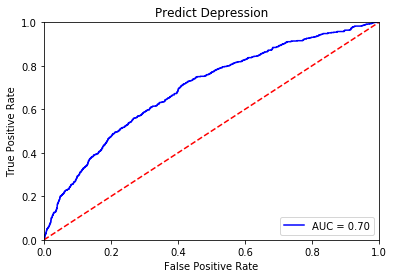

In [98]:
plt.title('Predict Depression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#Over sampling

In [62]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_sample(X_train, y_train)

In [64]:
y_res.sum()

27566

In [65]:
y_train.sum()

2471

Run Random Forest on X_res, y_res

In [109]:
os_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [110]:
os_clf.fit(X_res, y_res)
prob = os_clf.predict_proba(X_test)[:,1]
prob

array([0.04      , 0.57943626, 0.02666667, ..., 0.01333333, 0.22666667,
       0.01212121])

In [111]:
thr = np.arange(0.01, 0.2, 0.01)
#thr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,0.15, 0.2, 0.25, 0.3, 0.35]
recalls = []
precisions = []
y_pred = []

In [112]:
for t in thr:
    y_pred = [1 if x > t else 0 for x in prob]
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recalls.append(recall)
    precisions.append(precision)
    print('for ',t)
    print('recall: ', recall_score(y_test, y_pred))
    print('precision: ', precision_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred).ravel())
    print('f1 score: ', f1_score(y_test, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    print(metrics.auc(fpr, tpr))

for  0.01
recall:  0.9235569422776911
precision:  0.0925433797092387
[1064 5805   49  592]
f1 score:  0.16822961068485365
0.5392278815333718
for  0.02
recall:  0.8845553822152886
precision:  0.0970724191063174
[1595 5274   74  567]
f1 score:  0.17494600431965443
0.5583790159001905
for  0.03
recall:  0.8361934477379095
precision:  0.09986957331842743
[2038 4831  105  536]
f1 score:  0.17842876165113183
0.5664443727261392
for  0.04
recall:  0.797191887675507
precision:  0.10346223931970035
[2441 4428  130  511]
f1 score:  0.18315412186379929
0.5762782847898571
for  0.05
recall:  0.7893915756630265
precision:  0.10299206187665377
[2462 4407  135  506]
f1 score:  0.1822110190853439
0.5739067355677194
for  0.060000000000000005
recall:  0.750390015600624
precision:  0.1061575811079232
[2819 4050  160  481]
f1 score:  0.1860015467904099
0.5803922708662604
for  0.06999999999999999
recall:  0.7160686427457098
precision:  0.10980861244019138
[3148 3721  182  459]
f1 score:  0.19041692594897325
0

In [94]:
feature_importances = pd.DataFrame(os_clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [95]:
feature_importances.index


Index([ 'IRALCFY', 'IRALCAGE',   'SUMAGE', 'IRCIGAGE', 'EDUCCAT2',   'INCOME',
       'IRCGRAGE',   'CATAG6',  'IRCIGFM',   'IRMJFY',    'IRSEX', 'NEWRACE2',
        'IRANLFY', 'IRSNFAGE', 'ABODILAL', 'DPILLALC',  'IRTRNFY',  'IRHALFY',
        'IRCOCFY',    'CIGYR',          2,  'SUMFLAG',  'IRSTMFY',    'CGRYR',
        'TOBFLAG',  'IRINHFY',          7,    'ALCYR',    'SUMYR', 'IRCRKAGE',
        'SNFFLAG',          5,    'SNFYR',          6,  'IRSEDFY',  'IRHERFY',
        'ALCFLAG',          4,          3,  'IRCRKFY',  'CRKFLAG', 'DEPNDMRJ',
          'CRKYR'],
      dtype='object')

In [72]:
y_res.shape

(55132,)

In [113]:
X_res.shape

(55132, 43)

In [114]:
fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
roc_auc = metrics.auc(fpr, tpr)

Text(0.5,15,'False Positive Rate')

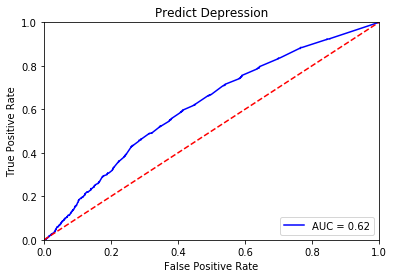

In [115]:
plt.title('Predict Depression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Over sampling + GradientBoosting 

In [116]:
gb_gs = GradientBoostingClassifier(n_estimators = 1700, 
                                   learning_rate=0.005, max_depth=7, max_features=9,
                                   min_samples_split=2000, min_samples_leaf=50, subsample=0.85)

In [117]:
gb_gs.fit(X_res, y_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=7,
              max_features=9, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=2000,
              min_weight_fraction_leaf=0.0, n_estimators=1700,
              presort='auto', random_state=None, subsample=0.85, verbose=0,
              warm_start=False)

In [118]:
prob = gb_gs.predict_proba(X_test)[:,1]
prob

array([0.52539781, 0.34344694, 0.27322845, ..., 0.22532553, 0.74148674,
       0.33844117])

In [119]:

thr = [0.2, 0.25, 0.3, 0.33, 0.35, 0.40, 0.5]
recalls = []
precisions = []
y_pred = []

In [120]:
for t in thr:
    y_pred = [1 if x > t else 0 for x in prob]
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recalls.append(recall)
    precisions.append(precision)
    print('for ',t)
    print('recall: ', recall_score(y_test, y_pred))
    print('precision: ', precision_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred).ravel())
    print('f1 score: ', f1_score(y_test, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    print(metrics.auc(fpr, tpr))

for  0.2
recall:  0.9656786271450858
precision:  0.09057652911911034
[ 654 6215   22  619]
f1 score:  0.16561872909698996
0.530444496277449
for  0.25
recall:  0.9375975039001561
precision:  0.09671709044093982
[1256 5613   40  601]
f1 score:  0.175346462436178
0.5602239957992554
for  0.3
recall:  0.9017160686427457
precision:  0.10505270810614321
[1945 4924   63  578]
f1 score:  0.18818167019371643
0.5924361388489605
for  0.33
recall:  0.8642745709828393
precision:  0.11027070063694268
[2399 4470   87  554]
f1 score:  0.19558693733451016
0.6067624128753184
for  0.35
recall:  0.8299531981279251
precision:  0.11463046757164404
[2760 4109  109  532]
f1 score:  0.2014388489208633
0.6158792049745754
for  0.4
recall:  0.7535101404056163
precision:  0.12914438502673797
[3612 3257  158  483]
f1 score:  0.2204976032869208
0.6396754370684363
for  0.5
recall:  0.5538221528861155
precision:  0.15701017249004864
[4963 1906  286  355]
f1 score:  0.2446588559614059
0.6381718130859462


In [83]:
t = 0.3
y_pred = [1 if x > t else 0 for x in prob]

In [124]:
fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
roc_auc = metrics.auc(fpr, tpr)

Text(0.5,15,'False Positive Rate')

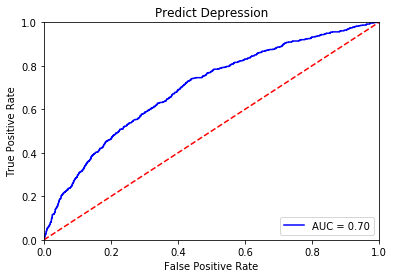

In [125]:
plt.title('Predict Depression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [92]:
'Resampled dataset shape {}'.format(Counter(y_res))

'Resampled dataset shape Counter({0: 27566, 1: 27566})'